# Using vae with clip embedding as part of lost function

Goal: 
1. test clip embedding as part of the lost function while removing histogram loss

In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, models as torchvision_models
from torch.utils.data import Dataset, DataLoader
import timm
import pandas as pd
from PIL import Image
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
from diffusers import StableDiffusionPipeline, AutoencoderKL, DiffusionPipeline
import clip

from torchvision.models import vgg16

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 1000
        # return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))

class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

class CLIPLoss(nn.Module):
    def __init__(self, clip_model, target_text, device):
        super().__init__()
        self.clip_model = clip_model
        self.target_text_embedding = self.clip_model.encode_text(clip.tokenize([target_text]).to(device)).detach()
        self.device = device

    def clip_preprocess_tensor(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),  # Resize the tensor directly
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # Normalize the tensor
        ])

    def forward(self, images):
        clip_preprocess = self.clip_preprocess_tensor()
        images_clip_preprocessed = clip_preprocess(images)
        images_clip_embeddings = self.clip_model.encode_image(images_clip_preprocessed)
        clip_loss = 1 - torch.cosine_similarity(images_clip_embeddings, self.target_text_embedding).mean()
        return clip_loss

class Colorizer(LightningModule):
    def __init__(self, vae):
        super().__init__()
        self.model = vae
        vgg_model = vgg16(weights=True)
        self.loss_fn = VGGPerceptualLoss(vgg_model)
        self.mse_loss_fn = nn.MSELoss()  # MSE Loss function

        
        # device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.clip_model, _ = clip.load("ViT-B/32", device=device)
        # self.clip_loss_fn = CLIPLoss(self.clip_model, "vibrant beautiful colorful", device)

        self.hparams.learning_rate = 0.00001

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs).sample

        perceptual_loss = self.loss_fn(outputs, targets)
        # clip_loss = self.clip_loss_fn(outputs)
        mse_loss = self.mse_loss_fn(outputs, targets)  # Compute MSE loss

        # total_loss = perceptual_loss + clip_loss
        total_loss = perceptual_loss + mse_loss
        # total_loss = perceptual_loss
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('mse_loss', mse_loss)
        return total_loss


In [3]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
# # image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
# text = clip.tokenize(["beautiful", "colorful", "anime"]).to(device)

# with torch.no_grad():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
    
#     logits_per_image, logits_per_text = model(image, text)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [5]:
vae = torch.load('anything-vae.pth', map_location='cpu')

In [6]:
model = Colorizer(vae)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# chkpt_file = 'checkpoints/version_68.ckpt'
# model = Colorizer.load_from_checkpoint(chkpt_file, vae=vae, map_location='cpu')

In [8]:
data_folder = 'data/toy'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)

In [9]:
logger = loggers.TensorBoardLogger("tb_logs")
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | AutoencoderKL     | 83.7 M
1 | loss_fn     | VGGPerceptualLoss | 138 M 
2 | mse_loss_fn | MSELoss           | 0     
--------------------------------------------------
220 M     Trainable params
1.7 M     Non-trainable params
222 M     Total params
888.046   Total estimated model params size (MB)
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9:  28%|██▊       | 275/1000 [02:35<06:49,  1.77it/s, v_num=78] 

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [12]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          

In [17]:
idx = 1500
x, y = training_dataset[idx]
output = model(x.unsqueeze(0))

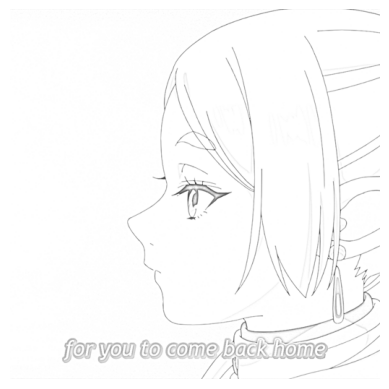

In [18]:
viewTensor(x)

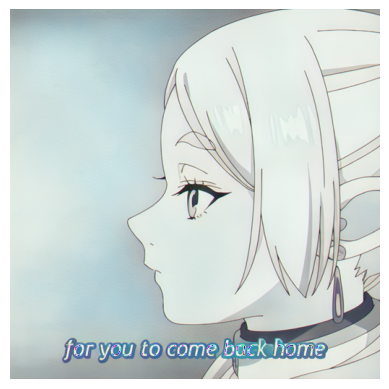

In [19]:
viewTensor(output.sample)

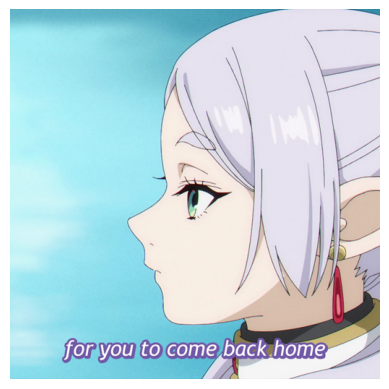

In [20]:
viewTensor(y)

In [191]:
def clip_preprocess_tensor():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the tensor directly
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # Normalize the tensor
    ])

In [192]:
processor = clip_preprocess_tensor()

In [204]:
def calculateLoss(images):
    text = clip.tokenize(["vibrant beautiful colorful"]).to('cpu')
    text_features = clip_model.encode_text(text)
    images = torch.stack([processor(image) for image in images])  # Apply preprocessing to each image in the batch
    image_features = clip_model.encode_image(images)
    return 1 - torch.cosine_similarity(image_features, text_features).mean()
calculateLoss([x])

tensor(0.8271, grad_fn=<RsubBackward1>)

In [205]:
calculateLoss([y])

tensor(0.7803, grad_fn=<RsubBackward1>)

In [206]:
calculateLoss(output.sample)

tensor(0.8226, grad_fn=<RsubBackward1>)

In [207]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model, preprocess = clip.load("ViT-B/32", device='cpu')

In [60]:
text = clip.tokenize(["beautiful colorful anime image"]).to('cpu')

In [61]:
text

tensor([[49406,  1215, 11444,  6469,  2867, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [66]:
text_features = clip_model.encode_text(text)

In [68]:
text_features.shape

torch.Size([1, 512])

In [71]:
# my_transform = Compose([
#         ToTensor(),
#         Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
# ])

# my_transform(torch.from_numpy(OpenCVImage)).unsqueeze(0).to(device)

In [74]:
clip_model.encode_image(y)

RuntimeError: The size of tensor a (768) must match the size of tensor b (16) at non-singleton dimension 2

In [72]:
clip_model(y, text_features)

RuntimeError: The size of tensor a (768) must match the size of tensor b (16) at non-singleton dimension 2

In [65]:
image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'CLIP.png'

In [63]:
clip_model.encode_image(y)

RuntimeError: The size of tensor a (768) must match the size of tensor b (16) at non-singleton dimension 2

In [46]:
# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(y)
    text_features = clip_model.encode_text(text)
    
    logits_per_image, logits_per_text = clip_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)